In [1]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/lpin0002/Desktop/DMPipe/utils.py:62: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:50: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


In [2]:
lonmeshtrue, log10emeshtrue, latmeshtrue = np.meshgrid(spatialaxistrue, log10eaxistrue, spatialaxistrue)
lonmeshrecon, latmeshrecon = np.meshgrid(spatialaxis, spatialaxis)

logjacobtrue = makelogjacob(log10eaxistrue)    

In [3]:
numberoftruevaluesamples = int(1e4)
Nsamples=numberoftruevaluesamples
truelambda = 0.5
nsig = int(round(truelambda*Nsamples))
nbkg = int(round((1-truelambda)*Nsamples))

truelogmassval = 0.0

In [4]:
psfnorm_lonrecon_mesh, psfnorm_lontrue_mesh = np.meshgrid(spatialaxis,spatialaxistrue)

unnormedpsfvals = psf(np.array([psfnorm_lonrecon_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), np.array([psfnorm_lontrue_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), psfnorm_lonrecon_mesh.flatten()*0).reshape(psfnorm_lonrecon_mesh.shape)

/Users/lpin0002/Desktop/DMPipe/utils3d.py:86: RuntimeWarning: divide by zero encountered in log
  return np.log(psffull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,


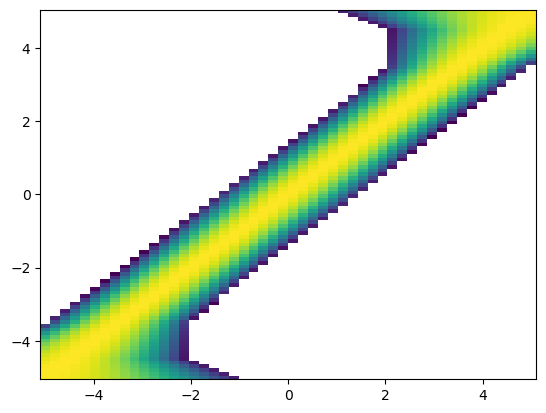

In [5]:
plt.figure()
plt.pcolormesh(spatialaxis, spatialaxistrue, unnormedpsfvals)
plt.show()

# Simulation

## Setup

### Background setup

In [6]:
logbkgpriorvalues = np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue))

logbkgpriorvalues = logbkgpriorvalues - special.logsumexp(logbkgpriorvalues.T+logjacobtrue)

logbkgpriorvalues.shape

/Users/lpin0002/Desktop/DMPipe/utils3d.py:155: RuntimeWarning: divide by zero encountered in log
  return np.log(bkgfull.evaluate(energy=10**logeval*u.TeV, fov_lon=np.abs(lon)*2*u.deg, fov_lat=np.abs(lat)*2*u.deg).value)


(28, 100, 100)

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/1007004851.py:38: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/1007004851.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


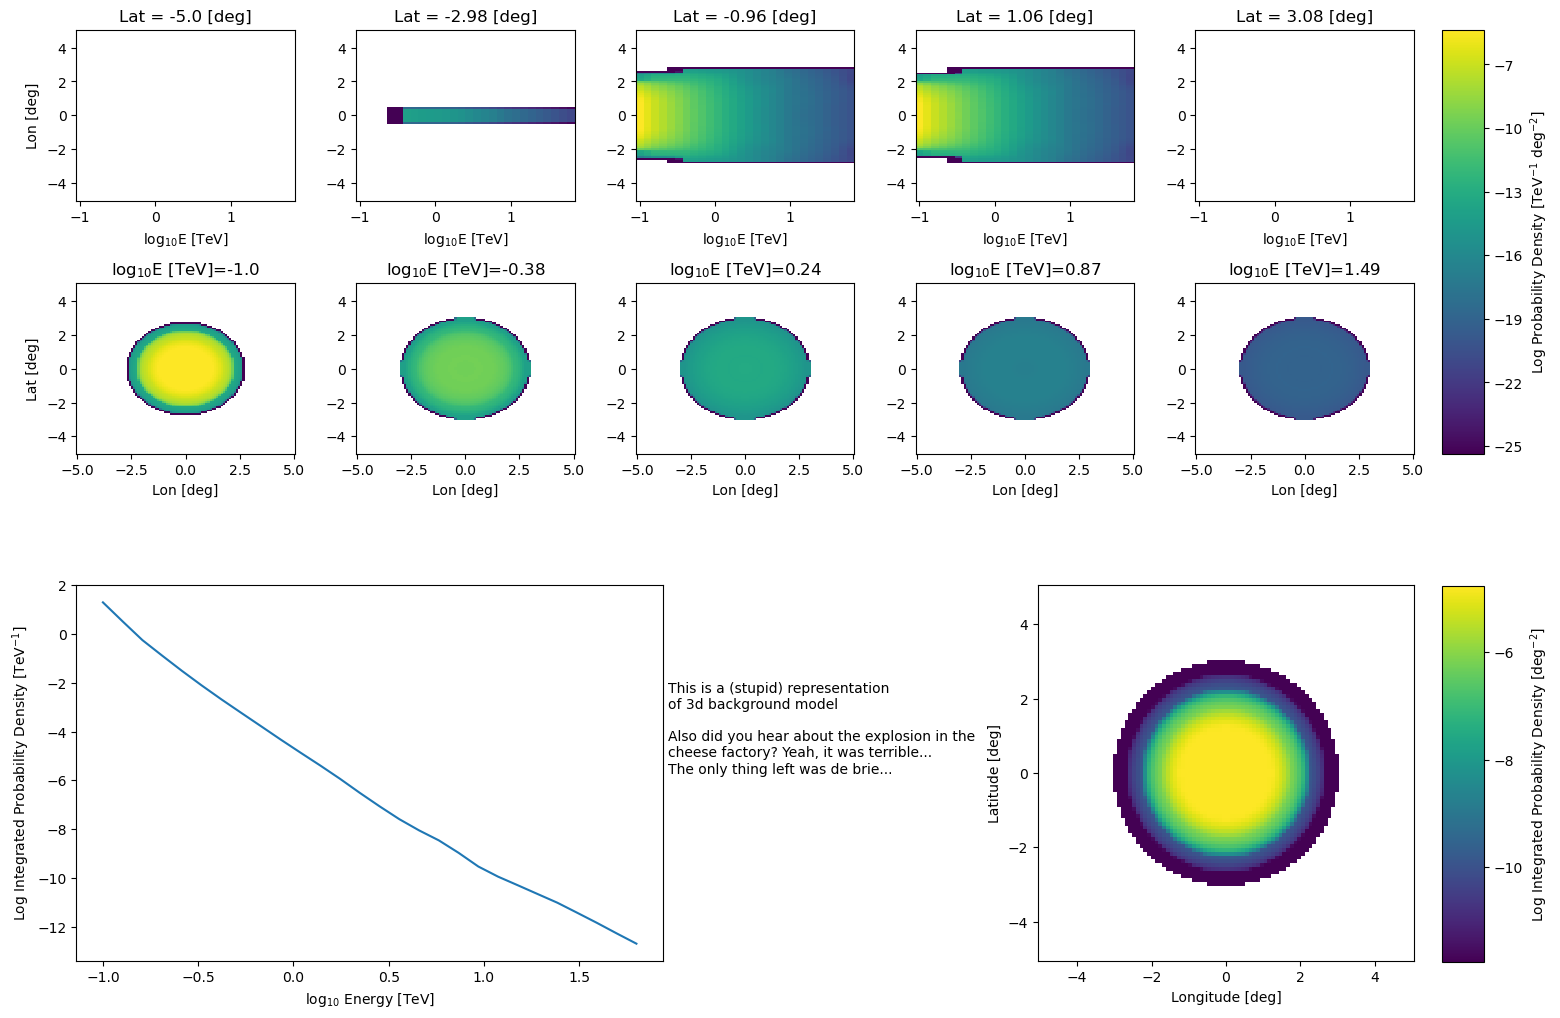

In [7]:
fig,axs = plt.subplots(4,5, figsize=(14,10))


maxval = np.max(logbkgpriorvalues)


spaceconverter = int(np.round(spatialaxistrue.shape[0]/5))
axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logbkgpriorvalues[:,:,index*spaceconverter].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[index*spaceconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))
# fig.tight_layout(pad=5.0)
plt.show()

### Signal Setup

In [8]:
signalfunc = setup_full_fake_signal_dist(1.0, darkmatterdoubleinput)

In [9]:
log10emeshtrue.shape

(28, 100, 100)

In [10]:
logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

print(logsigpriorvalues.shape)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues.T+logjacobtrue))
logsigpriorvalues.shape

(100, 100)
(28,)
(28, 100, 100)
(28, 100, 100)


/Users/lpin0002/Desktop/DMPipe/BFCalc/createspectragrids.py:107: RuntimeWarning: divide by zero encountered in log
  return np.log(twodinterpolationfunc(logmDM, logenergy-logmDM))


(28, 100, 100)

In [11]:
lonmeshtrue[:,0,0]

array([-5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5., -5.,
       -5., -5.])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/4002233959.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/4002233959.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,14,22)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/4002233959.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


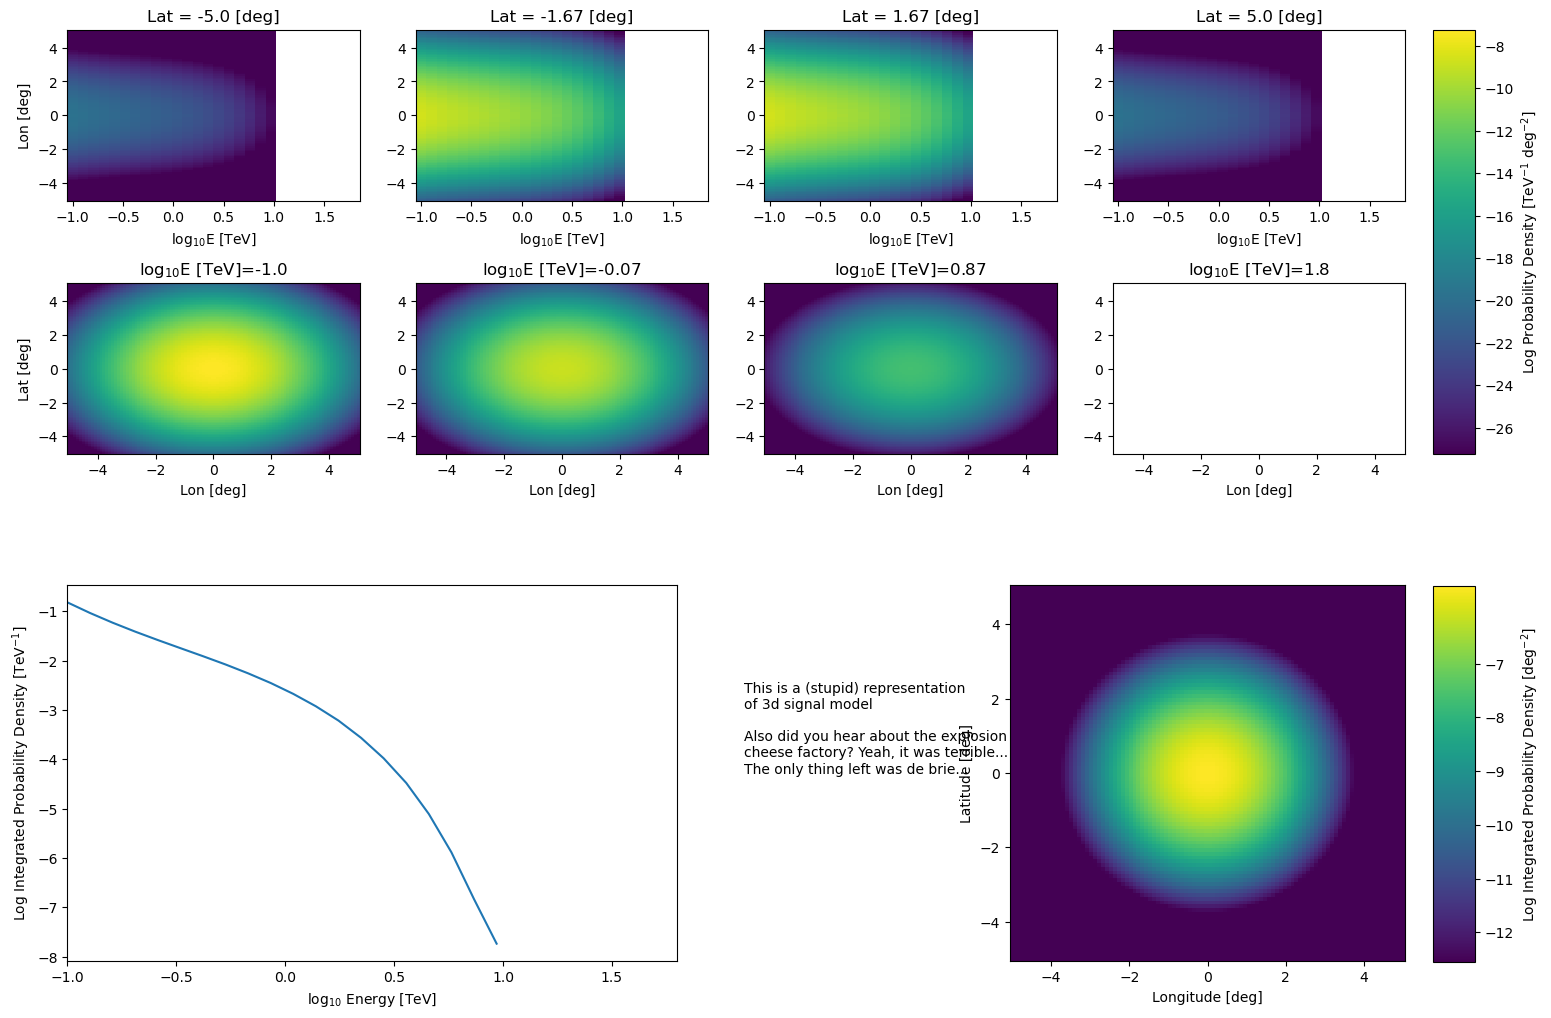

In [12]:
numslices = 4
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

spaceconverter = np.round(np.linspace(0, spatialaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, spatialaxistrue, logsigpriorvalues[:,:,int(spaceconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(spatialaxistrue[int(spaceconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[0,:,:], vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(spatialaxistrue, spatialaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:], vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,14,22)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d signal model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(spatialaxistrue, spatialaxistrue, integratedvals, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
# fig.tight_layout(pad=5.0)
plt.show()

## True Value Simulation

In [13]:
logsigbinnedprior = (logsigpriorvalues.T+logjacobtrue).T
flattened_logsigbinnedprior = logsigbinnedprior.flatten()


logbkgbinnedprior = (logbkgpriorvalues.T+logjacobtrue).T
flattened_logbkgbinnedprior = logbkgbinnedprior.flatten()

In [14]:
sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_logsigbinnedprior, Nsamples=nsig),logsigbinnedprior.shape)
siglogevals = log10eaxistrue[sigresultindices[0]]
siglonvals = spatialaxistrue[sigresultindices[1]]
siglatvals = spatialaxistrue[sigresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/2011522251.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/2011522251.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/2011522251.py:18: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


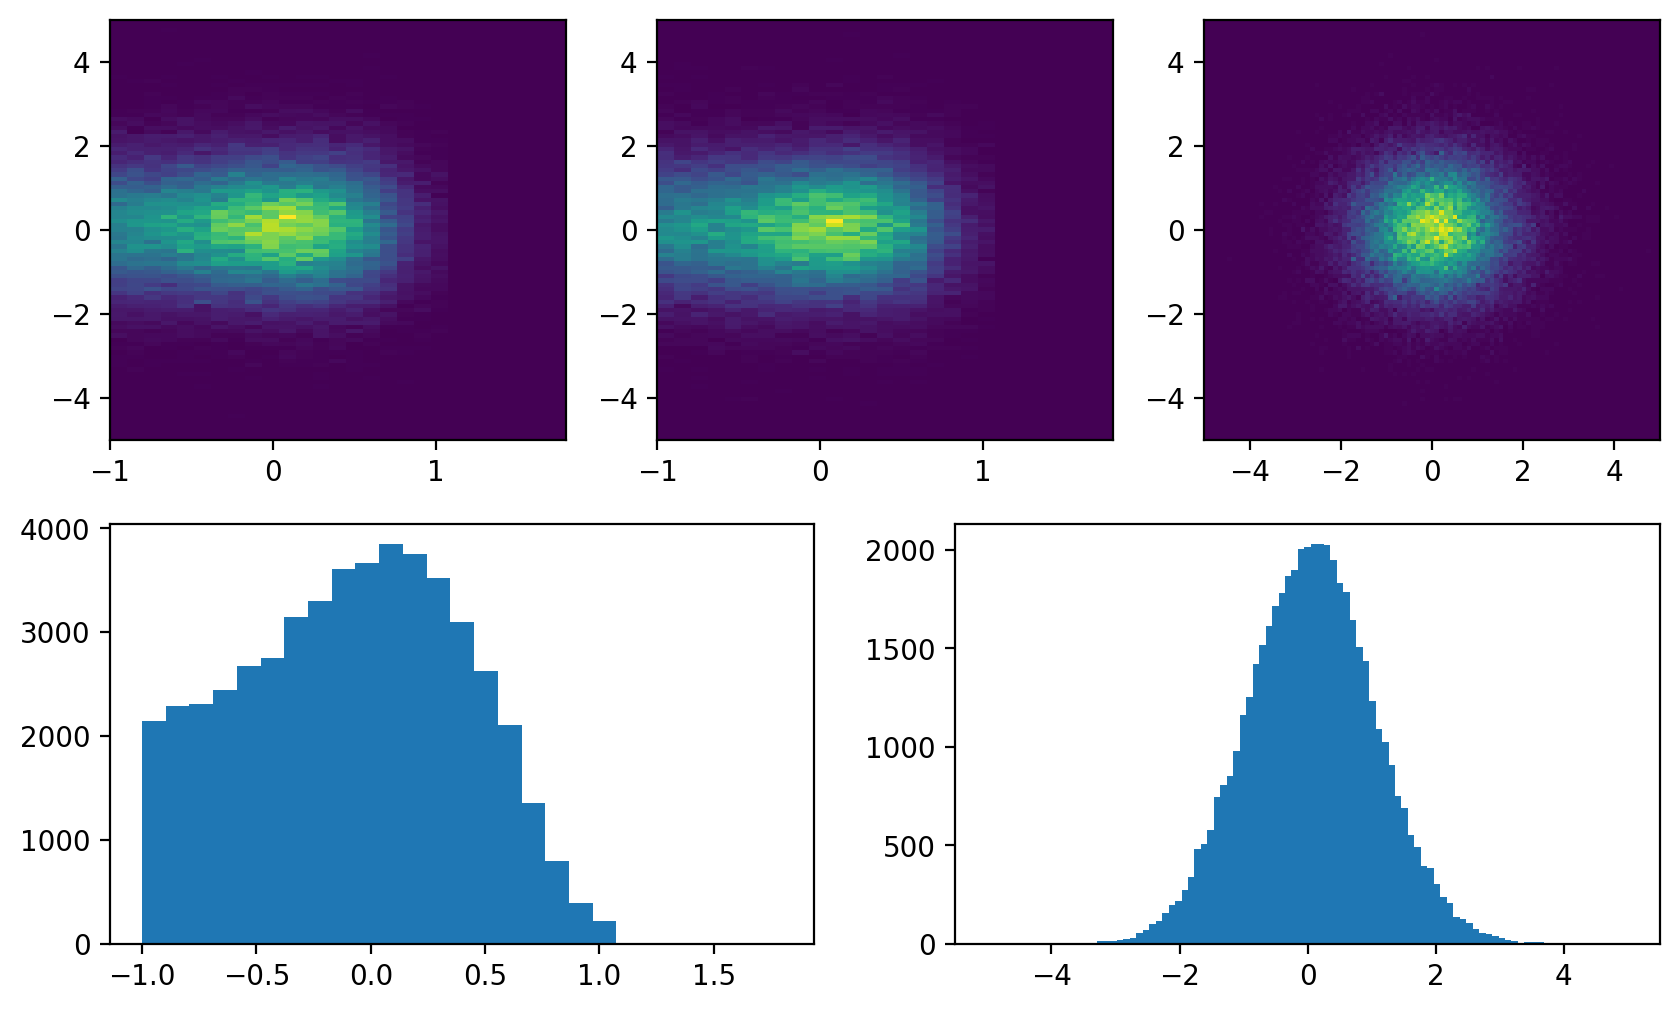

In [15]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(siglogevals, siglonvals, bins=[log10eaxistrue,spatialaxistrue])

plt.subplot(2,3,2)
plt.hist2d(siglogevals, siglatvals, bins=[log10eaxistrue,spatialaxistrue])

plt.subplot(2,3,3)
plt.hist2d(siglonvals, siglatvals, bins=[spatialaxistrue,spatialaxistrue])

plt.subplot(2,2,3)
plt.hist(siglogevals, bins=log10eaxistrue)

plt.subplot(2,2,4)
plt.hist(siglonvals, bins=spatialaxistrue)

plt.tight_layout()

plt.show()

In [16]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_logbkgbinnedprior, Nsamples=nbkg),logbkgbinnedprior.shape)
bkglogevals = log10eaxistrue[bkgresultindices[0]]
bkglonvals = spatialaxistrue[bkgresultindices[1]]
bkglatvals = spatialaxistrue[bkgresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/1054965026.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/1054965026.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_69520/1054965026.py:18: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


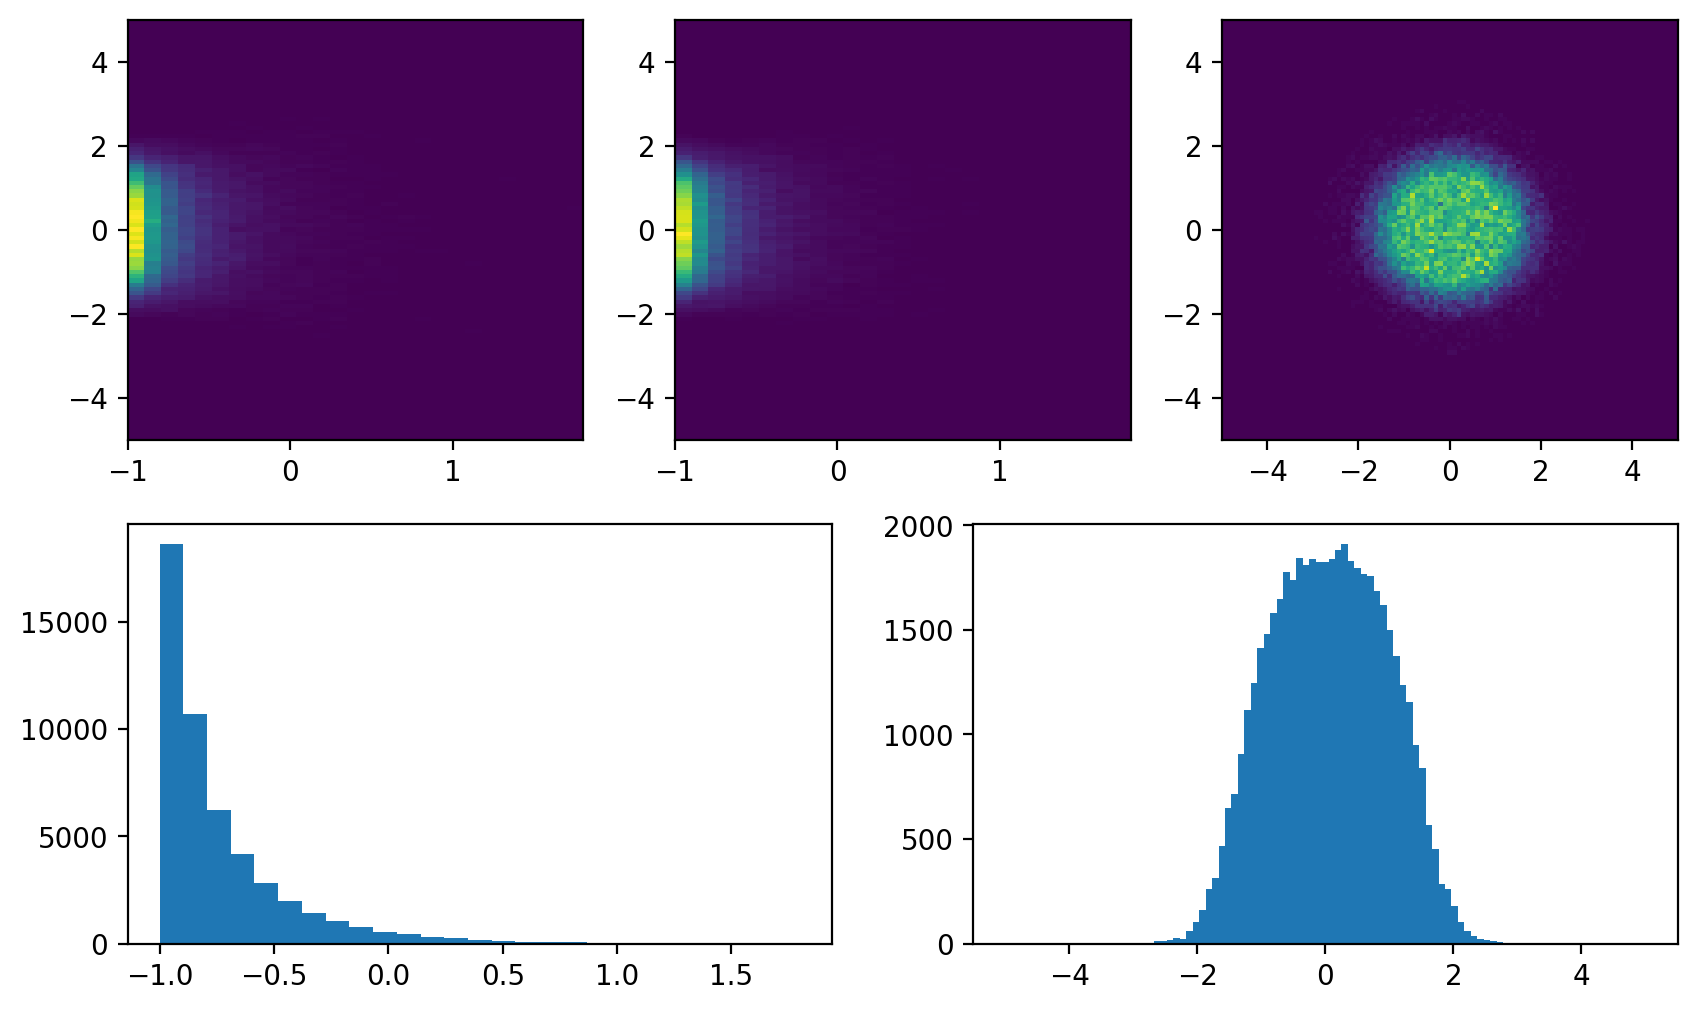

In [17]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkglogevals, bkglonvals, bins=[log10eaxistrue,spatialaxistrue])

plt.subplot(2,3,2)
plt.hist2d(bkglogevals, bkglatvals, bins=[log10eaxistrue,spatialaxistrue])

plt.subplot(2,3,3)
plt.hist2d(bkglonvals, bkglatvals, bins=[spatialaxistrue,spatialaxistrue])

plt.subplot(2,2,3)
plt.hist(bkglogevals, bins=log10eaxistrue)

plt.subplot(2,2,4)
plt.hist(bkglonvals, bins=spatialaxistrue)

plt.tight_layout()

plt.show()

## Reconstructed Value Simulation

In [18]:
for coord in np.array([siglonvals, siglatvals]).T:
    print(coord)

[ 1.36363636 -1.36363636]
[-0.95959596 -0.75757576]
[0.35353535 0.45454545]
[ 0.55555556 -0.35353535]
[-0.25252525 -0.25252525]
[-0.55555556  0.35353535]
[-1.86868687  0.75757576]
[0.95959596 0.85858586]
[-0.55555556 -1.06060606]
[-0.65656566  1.46464646]
[-1.86868687  0.45454545]
[ 1.56565657 -2.07070707]
[1.06060606 0.05050505]
[-1.76767677 -1.06060606]
[ 0.35353535 -1.26262626]
[-1.36363636 -0.65656566]
[1.06060606 0.25252525]
[-0.85858586  0.75757576]
[-0.05050505  1.66666667]
[ 0.15151515 -1.96969697]
[ 1.06060606 -0.45454545]
[-0.55555556 -1.46464646]
[-0.95959596 -0.75757576]
[-1.56565657  1.06060606]
[0.65656566 0.05050505]
[-0.55555556  0.15151515]
[ 0.75757576 -0.85858586]
[0.15151515 0.45454545]
[ 0.15151515 -1.26262626]
[-1.46464646 -0.25252525]
[-0.35353535  0.25252525]
[ 0.15151515 -1.46464646]
[-1.56565657 -1.46464646]
[-0.15151515 -0.35353535]
[ 0.15151515 -0.25252525]
[-0.55555556 -0.15151515]
[-0.15151515 -0.65656566]
[-0.35353535  1.46464646]
[-1.06060606  1.36363636

### Signal

In [19]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])]

  0%|          | 0/50000 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils3d.py:73: RuntimeWarning: divide by zero encountered in log
  return np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 50000/50000 [00:25<00:00, 1956.86it/s]


In [20]:
signal_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])
signal_reshaped_indices = np.unravel_index(signal_spatial_indices, shape=lonmeshrecon.shape)
signal_lon_measured = spatialaxis[signal_reshaped_indices[0]]
signal_lat_measured = spatialaxis[signal_reshaped_indices[1]]


100%|██████████| 50000/50000 [04:42<00:00, 176.99it/s]


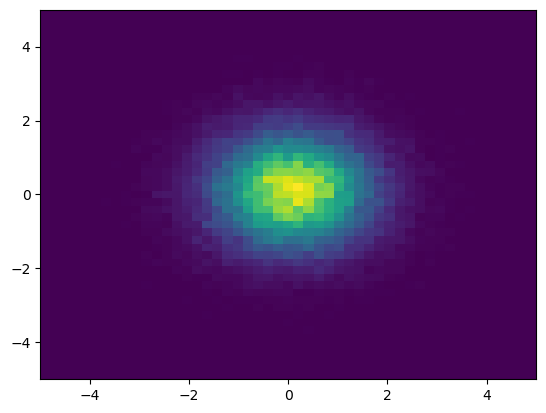

In [21]:
plt.figure()
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=[spatialaxis, spatialaxis])
plt.show()

### Background

In [22]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])]

100%|██████████| 50000/50000 [00:25<00:00, 1981.88it/s]


In [23]:
bkg_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), coord, logeval).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])
bkg_reshaped_indices = np.unravel_index(bkg_spatial_indices, shape=lonmeshrecon.shape)
bkg_lon_measured = spatialaxis[bkg_reshaped_indices[0]]
bkg_lat_measured = spatialaxis[bkg_reshaped_indices[1]]


 35%|███▌      | 17506/50000 [01:39<03:07, 173.10it/s]

KeyboardInterrupt: 

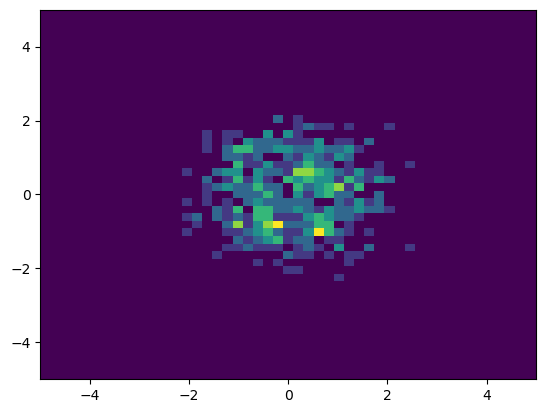

In [ ]:
plt.figure()
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[spatialaxis, spatialaxis])
plt.show()